In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras.layers import Embedding, BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [2]:
df = pd.read_csv("train.txt",
                 delimiter=';', header=None, names=['sentence','label'])

val_df = pd.read_csv("val.txt",
                 delimiter=';', header=None, names=['sentence','label'])

ts_df = pd.read_csv("test.txt",
                 delimiter=';', header=None, names=['sentence','label'])

In [3]:
df

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [4]:
val_df

,sentence,label
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy
...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness
1996,i constantly worry about their fight against n...,joy
1997,i feel its important to share this info for th...,joy
1998,i truly feel that if you are passionate enough...,joy


In [5]:
ts_df

,sentence,label
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness
...,...,...
1995,i just keep feeling like someone is being unki...,anger
1996,im feeling a little cranky negative after this...,anger
1997,i feel that i am useful to my people and that ...,joy
1998,im feeling more comfortable with derby i feel ...,joy


In [6]:
df['label'].unique()


array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [7]:
df.label.value_counts()


joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: label, dtype: int64

In [8]:
tr_text = df['sentence']
tr_label = df['label']

val_text = val_df['sentence']
val_label = val_df['label']

ts_text = ts_df['sentence']
ts_label = ts_df['label']

In [9]:
encoder = LabelEncoder()
tr_label = encoder.fit_transform(tr_label)
val_label = encoder.transform(val_label)
ts_label = encoder.transform(ts_label)

In [10]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(tr_text) 
                            
sequences = tokenizer.texts_to_sequences(tr_text)

tr_x = pad_sequences(sequences, maxlen=50) 
tr_y = to_categorical(tr_label)

sequences = tokenizer.texts_to_sequences(val_text)
val_x = pad_sequences(sequences, maxlen=50)
val_y = to_categorical(val_label)

sequences = tokenizer.texts_to_sequences(ts_text)
ts_x = pad_sequences(sequences, maxlen=50)
ts_y = to_categorical(ts_label)

In [11]:
max_words = 10000
max_len = 50
embedding_dim = 64

In [12]:
# Branch 1
branch1 = Sequential()
branch1.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch1.add(Conv1D(64, 3, padding='same', activation='relu'))
branch1.add(BatchNormalization())
branch1.add(ReLU())
branch1.add(Dropout(0.5))
branch1.add(GlobalMaxPooling1D())

# Branch 2
branch2 = Sequential()
branch2.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch2.add(Conv1D(64, 3, padding='same', activation='relu'))
branch2.add(BatchNormalization())
branch2.add(ReLU())
branch2.add(Dropout(0.5))
branch2.add(GlobalMaxPooling1D())

concatenated = Concatenate()([branch1.output, branch2.output])

hid_layer = Dense(128, activation='relu')(concatenated)
dropout = Dropout(0.5)(hid_layer)
output_layer = Dense(6, activation='softmax')(dropout)

model = Model(inputs=[branch1.input, branch2.input], outputs=output_layer)


In [13]:
model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_input (InputLayer)   [(None, 50)]         0           []                               
                                                                                                  
 embedding_1_input (InputLayer)  [(None, 50)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 64)       640000      ['embedding_input[0][0]']        
                                                                                                  
 embedding_1 (Embedding)        (None, 50, 64)       640000      ['embedding_1_input[0][0]']      
                                                                                              

In [14]:
GlobalMaxPooling1D??


In [15]:
batch_size = 128
epochs = 25
history = model.fit([tr_x, tr_x], tr_y, epochs=epochs, batch_size=batch_size,
                    validation_data=([val_x, val_x], val_y))

Epoch 1/25
125/125 [==============================] - 4s 28ms/step - loss: 1.7782 - accuracy: 0.3028 - precision: 0.3044 - recall: 0.0511 - val_loss: 1.7614 - val_accuracy: 0.3645 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
125/125 [==============================] - 3s 28ms/step - loss: 1.5952 - accuracy: 0.3419 - precision: 0.4631 - recall: 0.0318 - val_loss: 1.7367 - val_accuracy: 0.3680 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
125/125 [==============================] - 4s 29ms/step - loss: 1.5473 - accuracy: 0.3722 - precision: 0.5387 - recall: 0.0569 - val_loss: 1.7050 - val_accuracy: 0.4305 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
125/125 [==============================] - 4s 28ms/step - loss: 1.4677 - accuracy: 0.4177 - precision: 0.6329 - recall: 0.1209 - val_loss: 1.6121 - val_accuracy: 0.4890 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
125/125 [==============================] - 4s 29ms/step -

In [16]:
(loss, accuracy, percision, recall) = model.evaluate([ts_x, ts_x], ts_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, Precision: {round(percision, 2)}, Recall: {round(recall, 2)}')

63/63 [==============================] - 0s 3ms/step - loss: 0.2126 - accuracy: 0.9085 - precision: 0.9184 - recall: 0.9005
Loss: 0.21, Accuracy: 0.91, Precision: 0.92, Recall: 0.9


In [17]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

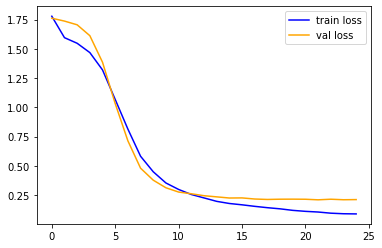

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss , 'b' , label = 'train loss')
plt.plot(val_loss , 'orange' , label = 'val loss')

plt.legend()
plt.show()


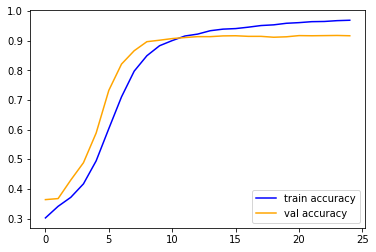

In [19]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(accuracy , 'b' , label = 'train accuracy')
plt.plot(val_accuracy , 'orange' , label = 'val accuracy')

plt.legend()
plt.show()